In [0]:
#-----installing ktrain library to employ learning rate schedule-------#
!pip3 install ktrain

  Stored in directory: /root/.cache/pip/wheels/66/20/65/9837200c0599c8be93473586d3ecebb6c45fc039537898c2e6
Successfully built ktrain


In [0]:
#--------------importing packages----------------#
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np
from sklearn.model_selection import StratifiedKFold
import ktrain
from ktrain import vision as vis
import matplotlib.pyplot as plt


#---------loading cifar10 from keras.datasets-----------------#
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x=[0]*60000
x[:50001]=x_train
x[50000:]=x_test
y=[0]*60000
y[:50001]=y_train
y[50000:]=y_test
x=np.array(x)  #Since there is no requirment of test set for implementing stratified K fold, all the images are stored in 'x'
y=np.array(y)  #All the labels are in 'y'


In [37]:
print(x.shape)  #dataset contains 60,000 images of dimensions 32*32*3 (height*width*channels)
print(y.shape)  #likewise there are 60,000 labels

(60000, 32, 32, 3)
(60000, 1)


In [0]:
#-----------normalization(z-score)-----------------------#
mean = np.mean(x,axis=(0,1,2,3))
std = np.std(x,axis=(0,1,2,3))
x = (x-mean)/(std+1e-7)


#-------------------One Hot Encoding---------------# 
num_classes = 10
y_label = np_utils.to_categorical(y,num_classes)


W0619 12:10:45.751612 140306142189440 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0619 12:10:45.766178 140306142189440 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0619 12:10:45.781641 140306142189440 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0619 12:10:45.794484 140306142189440 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0619 12:10:45.808433 140306142189440 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0619 12:10:45.822609 140306142189440 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0619 12:10:45.837303 140306

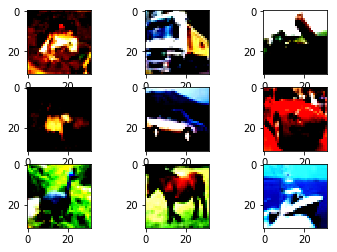

In [7]:
#---------plotting first few images-------------#

for i in range(9):
	plt.subplot(330 + 1 + i) # define subplot
	plt.imshow(x[i])  # define subplot
plt.show()  # define subplot

#-----10 classes in cifar10 dataset are ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']----------#

In [0]:
#------------------defining the cnn model------------------------#

def define_model():
  baseMapNum = 32
  weight_decay = 1e-4
  model = Sequential() #intializing the model
  
  # 32 conv layers of size 3*3 and padding with values same as edge values, output shape would be 32*32*32  
  model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(32,32,3))) 
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2)) #dropout with probability 0.2
  
  #64 conv layers of size 3*3 and the output shape will be 32*32*64
  model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  
  #128 conv layers of size 3*3 and output shape will be 32*32*128
  model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))
  return model
 


In [30]:
#------------------summary of the defined model---------------------#
model = define_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
__________

W0619 12:10:51.986640 140306142189440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 12:10:52.013617 140306142189440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 12:10:52.018721 140306142189440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 12:10:52.053021 140306142189440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0619 12:10:52.054164 1403061421

simulating training for different learning rates... this may take a few moments...


W0619 12:10:56.002864 140306142189440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
60000/60000 [==============================] - 29s 477us/step - loss: 3.9611 - acc: 0.1794
Epoch 2/2
32864/60000 [===============>..............] - ETA: 10s - loss: 2.7919 - acc: 0.3230

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


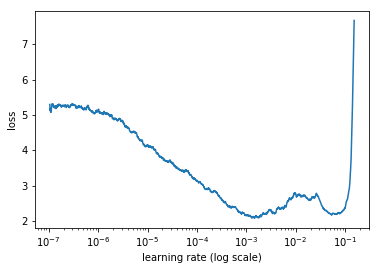

In [9]:
#------wrap model and data in ktrain.learner object----------------#
model = define_model()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
learner = ktrain.get_learner(model, train_data=(x, y_label),val_data = (x, y_label))


#---------------we use the Learning Rate Finder in ktrain to find a good initial learning rate.------------#
learner.lr_find()
learner.lr_plot()


In [38]:
#-----------------using the print_layers function to examine the layers of the created network.-----------------#
learner.print_layers()

0 (trainable=True) : <keras.layers.convolutional.Conv2D object at 0x7f9ab436db38>
1 (trainable=True) : <keras.layers.core.Activation object at 0x7f9ab3b07390>
2 (trainable=True) : <keras.layers.normalization.BatchNormalization object at 0x7f9ab3b070f0>
3 (trainable=True) : <keras.layers.convolutional.Conv2D object at 0x7f9ab3c2ca90>
4 (trainable=True) : <keras.layers.core.Activation object at 0x7f9ab3d16d30>
5 (trainable=True) : <keras.layers.normalization.BatchNormalization object at 0x7f9ab3f06e10>
6 (trainable=True) : <keras.layers.pooling.MaxPooling2D object at 0x7f9ab3ee5d68>
7 (trainable=True) : <keras.layers.core.Dropout object at 0x7f9ab4011400>
8 (trainable=True) : <keras.layers.convolutional.Conv2D object at 0x7f9ab3e18208>
9 (trainable=True) : <keras.layers.core.Activation object at 0x7f9ab429e2b0>
10 (trainable=True) : <keras.layers.normalization.BatchNormalization object at 0x7f9ab429e860>
11 (trainable=True) : <keras.layers.convolutional.Conv2D object at 0x7f9ab3ad8780>
1

In [10]:


kfold=StratifiedKFold(n_splits=3,shuffle=True)  #defining 3 folds with random shuffling for using StratifiedKFold
kfold_acc=[]  #empty list declaration to store validation accuracy for each fold
kfold_loss=[] #list to store validation loss for each fold

#---------training with adaptive learning rate-----------#
for train,test in kfold.split(x,y):
  model = define_model()
  model.compile(loss='categorical_crossentropy',      #compiling the model using categorical_crossentropy loss function and adam optimizer 
          optimizer='adam',
          metrics=['accuracy'])
  learner = ktrain.get_learner(model, 
                             train_data=(x[train], y_label[train]),
                             val_data = (x[test], y_label[test]))
  learner.autofit(0.005)
  loss, acc = learner.model.evaluate(x=x[test], y=y_label[test])
  print('final loss:%s, final score:%s' % (loss, acc))
  kfold_acc.append(acc)
  kfold_loss.append(loss)
  


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.005...
Train on 40000 samples, validate on 20000 samples
Epoch 1/1024
  416/40000 [..............................] - ETA: 1:53 - loss: 4.0250 - acc: 0.1466

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135362). Check your callbacks.
  % delta_t_median)


40000/40000 [==============================] - 21s 525us/step - loss: 2.2627 - acc: 0.3939 - val_loss: 1.5131 - val_acc: 0.5216
Epoch 2/1024
40000/40000 [==============================] - 20s 492us/step - loss: 1.4329 - acc: 0.5385 - val_loss: 1.0991 - val_acc: 0.6523
Epoch 3/1024
40000/40000 [==============================] - 20s 490us/step - loss: 1.1537 - acc: 0.6297 - val_loss: 0.9835 - val_acc: 0.7111
Epoch 4/1024
40000/40000 [==============================] - 20s 491us/step - loss: 1.1224 - acc: 0.6639 - val_loss: 0.9494 - val_acc: 0.7370
Epoch 5/1024
40000/40000 [==============================] - 19s 486us/step - loss: 1.0556 - acc: 0.6992 - val_loss: 0.8761 - val_acc: 0.7642
Epoch 6/1024
40000/40000 [==============================] - 19s 483us/step - loss: 1.0184 - acc: 0.7193 - val_loss: 0.8615 - val_acc: 0.7794
Epoch 7/1024
40000/40000 [==============================] - 19s 484us/step - loss: 1.0051 - acc: 0.7310 - val_loss: 0.8703 - val_acc: 0.7840
Epoch 8/1024
40000/40000 [

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215751). Check your callbacks.
  % delta_t_median)


40000/40000 [==============================] - 21s 536us/step - loss: 2.2018 - acc: 0.3974 - val_loss: 1.5923 - val_acc: 0.5394
Epoch 2/1024
40000/40000 [==============================] - 21s 515us/step - loss: 1.6270 - acc: 0.5064 - val_loss: 1.2129 - val_acc: 0.6124
Epoch 3/1024
40000/40000 [==============================] - 21s 516us/step - loss: 1.2712 - acc: 0.5921 - val_loss: 1.0297 - val_acc: 0.6831
Epoch 4/1024
40000/40000 [==============================] - 21s 514us/step - loss: 1.1498 - acc: 0.6475 - val_loss: 0.9444 - val_acc: 0.7279
Epoch 5/1024
40000/40000 [==============================] - 21s 514us/step - loss: 1.0836 - acc: 0.6806 - val_loss: 0.9058 - val_acc: 0.7490
Epoch 6/1024
40000/40000 [==============================] - 21s 514us/step - loss: 1.0560 - acc: 0.7041 - val_loss: 0.9023 - val_acc: 0.7610
Epoch 7/1024
40000/40000 [==============================] - 21s 513us/step - loss: 1.0345 - acc: 0.7231 - val_loss: 0.8781 - val_acc: 0.7802
Epoch 8/1024
40000/40000 [

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.318692). Check your callbacks.
  % delta_t_median)


40000/40000 [==============================] - 23s 568us/step - loss: 2.1998 - acc: 0.3916 - val_loss: 1.4077 - val_acc: 0.5475
Epoch 2/1024
40000/40000 [==============================] - 20s 505us/step - loss: 1.4228 - acc: 0.5513 - val_loss: 1.0549 - val_acc: 0.6601
Epoch 3/1024
40000/40000 [==============================] - 20s 506us/step - loss: 1.1202 - acc: 0.6396 - val_loss: 0.9037 - val_acc: 0.7217
Epoch 4/1024
40000/40000 [==============================] - 20s 507us/step - loss: 1.0227 - acc: 0.6867 - val_loss: 0.8521 - val_acc: 0.7537
Epoch 5/1024
40000/40000 [==============================] - 21s 513us/step - loss: 0.9916 - acc: 0.7123 - val_loss: 0.8490 - val_acc: 0.7702
Epoch 6/1024
40000/40000 [==============================] - 20s 505us/step - loss: 0.9912 - acc: 0.7301 - val_loss: 0.8463 - val_acc: 0.7847
Epoch 7/1024
40000/40000 [==============================] - 20s 496us/step - loss: 0.9858 - acc: 0.7433 - val_loss: 0.8545 - val_acc: 0.7931
Epoch 8/1024
40000/40000 [

In [29]:
#print(kfold_acc)
#print(kfold_loss)
accuracy = np.mean(np.array(kfold_acc))   #final accuracy is the mean of validation accuracy obtained at each fold 
loss = np.mean(np.array(kfold_loss))         #final loss is obtained by the mean of validation loss obtained at each fold
print("Final Score:""{0:.2f}".format(accuracy*100)) 
print("Final loss:""{0:.2f}".format(loss))   

Final Score:86.17
Final loss:0.63
